# *Seeing Through Obstruction*

This tutorial is based on the paper:  
**"Seeing through Obstructions with Diffractive Cloaking (2022)"**  

The goal of this tutorial is to train a `depth-dependent Diffractive Optical Element (DOE)`, where the `Point Spread Function (PSF)` varies with depth. Specifically:  

- Light propagating from a `distant source` should **focus into a single point**.  
- Light originating from a `closer distance (with an obstruction)*`should **spread into a ring pattern**.  

By designing and training such a DOE, we aim to selectively manipulate wavefront propagation based on depth, enabling applications such as **seeing through obstructions** using diffractive cloaking techniques.

In [1]:
cd ../..

/home/gusah7787/project/pado-internal


/home/gusah7787/.pyenv/versions/3.9.21/envs/padoenv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## 🌊 **Step1: Import Pado**
First, you should import Pado. Make sure to install all the dependency :) 

In [2]:
import pado
from pado.math import mm, m, um, nm

import torch
import torchvision.transforms as T
from matplotlib import pyplot as plt

In [3]:
R, C = 1024, 1024 # number of rows and cols
dim = (1, 1, R, C)

wvl = 550 * nm # wavelength of the light
pitch = 3 * um # physical size of each pixel
far_distance = 5 * m # depth of obstacle
near_distance = 0.05 * m # depth of obstacle
sensor_distance = 10 * mm # distance between doe and sensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


## 🌠 **Step 2: Designing the Target Mask**

In this step, we design the target mask that defines the desired PSF patterns at each distance.  
These `target masks` guide the DOE optimization process by specifying how light should be distributed at the target plane for each depth.  
For example, the target mask for a far distance may focus light into a single point, while the mask for a short distance may spread light into a ring-shaped pattern.

In [4]:
def circle_mask(R, C, r) -> torch.tensor:
    """
    Generates a binary circular mask within an (R, C) grid.

    Parameters:
    R (int): Number of rows (height of the grid).
    C (int): Number of columns (width of the grid).
    r (float): Radius of the circle (normalized to the range [-1, 1]).

    Returns:
    torch.Tensor: A (R, C) tensor where the circular region is 1, and the rest is 0.
    """

    y, x = torch.meshgrid(torch.linspace(-1, 1, R), torch.linspace(-1, 1, C), indexing='xy')
    R = torch.sqrt(x * x + y * y)
    
    return (R < r).float()

def circle_ring_mask(R, C, r1, r2):
    """
    Generates a circular ring (annular) mask within an (R, C) grid.

    The mask consists of a hollow ring centered in the middle of the grid.
    Pixels between the inner radius (r1) and outer radius (r2) are set to 1,
    while others are set to 0.

    Parameters:
    R (int): Number of rows (height of the grid).
    C (int): Number of columns (width of the grid).
    r1 (float): Inner radius of the ring (normalized to [-1, 1]).
    r2 (float): Outer radius of the ring (normalized to [-1, 1]).

    Returns:
    torch.Tensor: A (R, C) tensor where the ring-shaped region is 1, and the rest is 0.
    """

    return circle_mask(R, C, r2) - circle_mask(R, C, r1)

In [5]:
# Target masks
near_mask = circle_ring_mask(R, C, 0.95, 1.0).cuda()
far_mask = circle_mask(R, C, 0.01).cuda()
reverse_near_mask = 1 - near_mask
reverse_far_mask = 1 - far_mask

# Maximize target mask area, Minimizing reverse mask area
near_target = -near_mask / near_mask.sum() + 5 * reverse_near_mask / reverse_near_mask.sum()
far_target = -far_mask / far_mask.sum() + 5 * reverse_far_mask / reverse_far_mask.sum()

Now, let’s visualize the masks we just created.

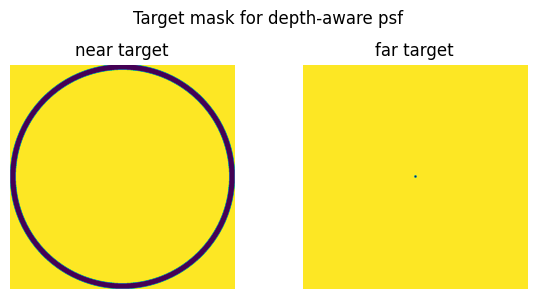

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle('Target mask for depth-aware psf')

ax[0].imshow(near_target.squeeze().cpu())
ax[0].axis('off')
ax[0].set_title('near target')
ax[1].imshow(far_target.squeeze().cpu())
ax[1].axis('off')
ax[1].set_title('far target')

plt.tight_layout()
plt.show()

## 🧪 **Step 3: DOE Training**

In this step, we directly train the `phase modulation` of the `DOE`.
The training is set to run for 400 epochs with a learning rate of 0.01.
The phase modulation of the DOE is defined as a tensor with requires_grad=True, allowing gradients to be tracked for optimization.

In [7]:
from torch.optim import Adam

material = pado.material.Material('FUSED_SILICA')
aperture = pado.optical_element.Aperture(dim, pitch, R * pitch, 'circle', wvl, device=device)

n_epoch = 400
lr = 0.01

# Parameter for the phase modulation to be trained
phase_shift = torch.zeros(1, R, C).requires_grad_(True)
optim = Adam([phase_shift], lr=0.01)

In the experimental optical setup, light sequentially passes through a  `DOE ` and a  `refractive lens ` before forming an image on the sensor.  However, when reproducing this setup using a  `Fresnel propagator `, the  `Nyquist criterion ` dictates that the required pixel count for accurate simulation increases significantly, making the approach computationally infeasible. To address this, we will use the  `Fraunhofer propagator ` instead.  

By definition,  `Fraunhofer propagation ` is equivalent to Fresnel diffraction combined with a  `refractive lens `, observed at the focal plane. This allows us to achieve the same effect while eliminating the need to explicitly model the refractive lens. Thus, in our simulation, we will use the  `Fraunhofer propagator ` and omit the refractive lens to maintain feasibility while preserving accuracy.

In [8]:
propagtor = pado.propagator.Propagator('Fraunhofer')

Designing the Function to Compute the `PSF`

In [9]:
def get_psf(z, doe, normalize=False):
    """
    Computes the Point Spread Function (PSF) at a given propagation distance.

    This function simulates the propagation of light through an optical system,
    optionally passing through a diffractive optical element (DOE)

    Parameters:
    z (float): Distance from the light source to the DOE/aperture.
    doe (object or None): A diffractive optical element (DOE) that modifies the wavefront.
                          If None, the light propagates without modification.
    normalize (bool, optional): If True, normalizes the PSF so that its sum equals 1.

    Returns:
    torch.Tensor: The computed PSF intensity distribution.
    """

    light = pado.light.Light(dim, pitch, wvl, device=device)
    light.set_spherical_light(z)

    out = light

    # Apply the DOE if provided
    if doe is not None:
        out = doe.forward(out)

    out = aperture.forward(out)
    out = propagtor.forward(out, sensor_distance)
    out = out.get_intensity()

    if normalize:
        out /= out.sum()
        
    return out

All preparations are complete. Now, let's start the training!

In [10]:
for epoch in range(1, n_epoch + 1):
    optim.zero_grad()

    doe = pado.optical_element.DOE(dim, pitch, material, wvl, device=device)
    doe.set_phase_change(phase_shift.cuda(), False)

    far_psf = get_psf(far_distance, doe)
    near_psf = get_psf(near_distance, doe)

    far_loss = (far_psf * far_target).sum()
    near_loss = (near_psf * near_target).sum()

    loss = far_loss * 0.0013 + near_loss
    loss.backward()

    optim.step()

    if epoch % 50 == 1:
        print('epoch: {}/{}  far_loss: {}, near_loss: {}'.format(epoch, n_epoch, far_loss.item(), near_loss.item()))

print('epoch: {}/{}  far_loss: {}, near_loss: {}'.format(epoch, n_epoch, far_loss.item(), near_loss.item()))


epoch: 1/400  far_loss: -10410023936.0, near_loss: 4455750.5
epoch: 51/400  far_loss: -10026913792.0, near_loss: 3846669.5
epoch: 101/400  far_loss: -8333058560.0, near_loss: 1420611.375
epoch: 151/400  far_loss: -7262812160.0, near_loss: -101594.1875
epoch: 201/400  far_loss: -6638213632.0, near_loss: -978406.0
epoch: 251/400  far_loss: -6156301312.0, near_loss: -1650289.75
epoch: 301/400  far_loss: -5788234752.0, near_loss: -2165345.5
epoch: 351/400  far_loss: -5491196416.0, near_loss: -2580667.0
epoch: 400/400  far_loss: -5247737344.0, near_loss: -2918117.25


## 📋 **Step 4: Check the Trained DOE**

In this step, we visualize the phase modulation of the trained  `DOE ` and directly observe the PSFs at each distance to evaluate how well the DOE learned the desired depth-aware behavior.

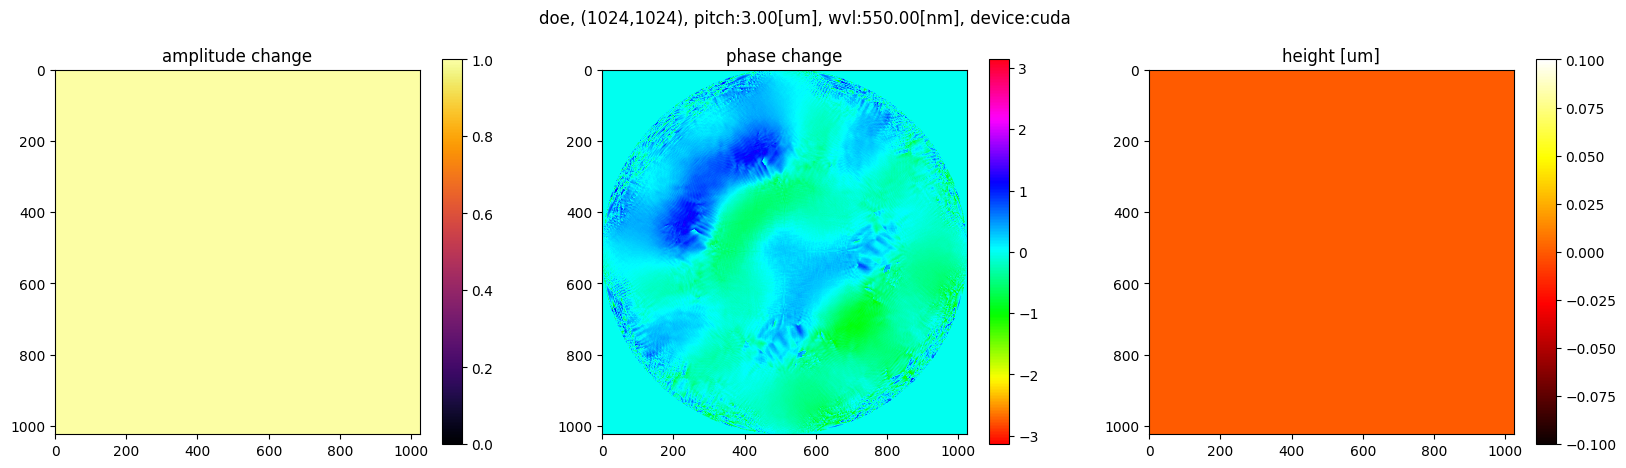

In [11]:
# lens = pado.optical_element.RefractiveLens(dim, pitch, far_distance, wvl, device='cuda')
doe = pado.optical_element.DOE(dim, pitch, material, wvl, device=device)
doe.set_phase_change(phase_shift.clone().detach().cuda(), False)

doe.visualize()

We compare the PSFs of the DOE and the refractive lens.
At a short distance (0.05m), unlike the lens, the trained DOE scatters the transmitted light into a ring shape.

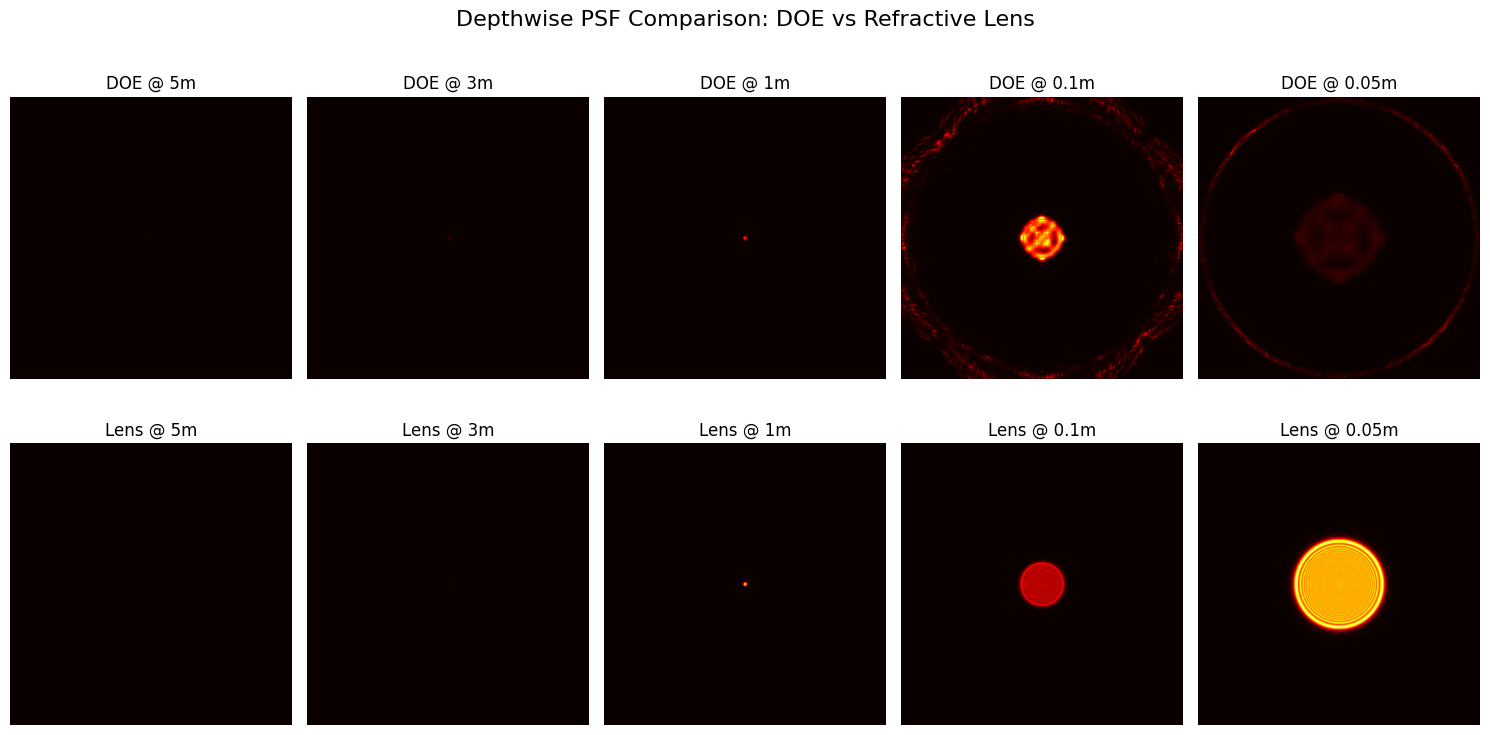

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle("Depthwise PSF Comparison: DOE vs Refractive Lens", fontsize=16)

for i, z in enumerate([5, 3, 1, 0.1, 0.05]):
    doe_psf = get_psf(z, doe, normalize=True)
    lens_psf = get_psf(z, None, normalize=True)

    axes[0][i].imshow(doe_psf.cpu().squeeze(), cmap='hot')
    axes[0][i].axis('off')
    axes[0][i].set_title(f'DOE @ {z}m')

    axes[1][i].imshow(lens_psf.cpu().squeeze(), cmap='hot')
    axes[1][i].axis('off')
    axes[1][i].set_title(f'Lens @ {z}m')

plt.tight_layout()
plt.show()

## 🪄 **Step 5: Seeing Through an Obstruction**

In this step, we conduct experiments using real images, applying the PSFs produced by the trained DOE to observe how the DOE performs when viewing through an obstruction.

In [21]:
from pado.math import fft, ifft
from PIL import Image

transforms = T.Compose([
    T.Resize((R, C)), 
    T.Grayscale(), 
    T.ToTensor(), 
    T.Lambda(lambda x: x[None].to(device))
])

obstacle_transform = T.Compose([
    T.Resize((R, C)), 
    T.ToTensor(), 
    T.Lambda(lambda x: x[None].to(device))
])

obstacle = Image.open('example/asset/noise.png')
obstacle = obstacle_transform(obstacle)
mask = (obstacle > 0.2).float()

image_far = Image.open('example/asset/bunny_1_1.png')
image_far = transforms(image_far)
image_near = obstacle * mask + image_far * (1 - mask)

In [22]:
far_psf = get_psf(z=far_distance, doe=doe, normalize=True)
near_psf = get_psf(z=near_distance, doe=doe, normalize=True)
lens_far_psf = get_psf(z=far_distance, doe=None, normalize=True)
lens_near_psf = get_psf(z=near_distance, doe=None, normalize=True)

The simulation is performed by convolving the far PSF and near PSF with the image.
Let's predefine the necessary functions for this experiment.

In [23]:
def convolution(image, kernel, linear=True):
    """
    Computes the convolution of an image with a kernel using Fourier Transform.

    Parameters:
    image (torch.Tensor): The input image (2D tensor).
    kernel (torch.Tensor): The convolution kernel (2D tensor).
    linear (bool, optional): If True, applies zero-padding to handle linear convolution 
                             instead of circular convolution (default: True).

    Returns:
    torch.Tensor: The real part of the convolved image.
    """

    # Apply padding for linear convolution
    pad = (C//2, C//2, R//2, R//2) if linear else None

    image_fft = fft(image, pad_width=pad)
    kernel_fft = fft(kernel, pad_width=pad)

    return ifft(image_fft * kernel_fft, pad_width=pad).real

def simulate(far_psf, near_psf):
    """
    Simulates the combined effect of two point spread functions (PSFs) on two images.

    This function applies convolution with different PSFs to two images, 
    and then blends them using a mask that determines the transition between 
    near and far image contributions.

    Parameters:
    far_psf (torch.Tensor): The PSF for the far image.
    near_psf (torch.Tensor): The PSF for the near image.

    Returns:
    torch.Tensor: The simulated blended image.
    """
    far_conv = convolution(image_far, far_psf)
    near_conv = convolution(image_near, near_psf)
    mask_conv = convolution(mask, near_psf)
    mask_conv = torch.clamp(1.5 * mask_conv, 0, 1)

    img_conv = near_conv * mask_conv + far_conv * (1 - mask_conv)

    return img_conv.detach().cpu()

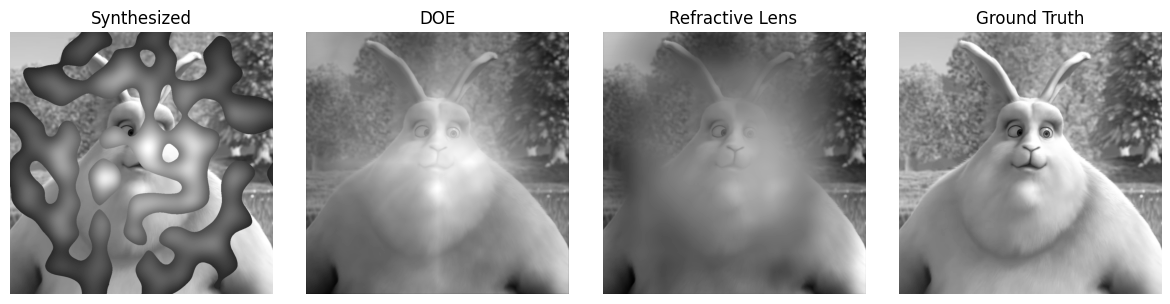

In [24]:
doe_result = simulate(far_psf, near_psf)
lens_result = simulate(lens_far_psf, lens_near_psf)

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(image_near.cpu().squeeze(), cmap='gray')
axes[1].imshow(doe_result.squeeze(), cmap='gray')
axes[2].imshow(lens_result.squeeze(), cmap='gray')
axes[3].imshow(image_far.cpu().squeeze(), cmap='gray')
axes[0].set_title('Synthesized')
axes[1].set_title('DOE')
axes[2].set_title('Refractive Lens')
axes[3].set_title('Ground Truth')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

plt.tight_layout()
plt.show()